# Upload and unzip data

In [ ]:
from zipfile import ZipFile

file_name = "/content/data.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.7.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia PyCall PyPlot StatsBase" # Plots"  #BenchmarkTools
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.7.2 on the current Colab Runtime...
2024-11-30 16:29:54 URL:https://julialang-s3.julialang.org/bin/linux/x64/1.7/julia-1.7.2-linux-x86_64.tar.gz [123295596/123295596] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package PyCall...
Installing Julia package PyPlot...
Installing Julia package StatsBase...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.7

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [1]:
versioninfo()

Julia Version 1.7.2
Commit bf53498635 (2022-02-06 15:21 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 (ORCJIT, broadwell)
Environment:
  JULIA_NUM_THREADS = 2


# Add Packages

In [2]:
using Pkg; Pkg.add(url="https://github.com/FrancescoCalvanese/FCSeqTools.jl");
using FCSeqTools, StatsBase, Statistics, LinearAlgebra, PyCall, PyPlot;
include("utils.jl");
using .utils;

     Cloning git-repo `https://github.com/FrancescoCalvanese/FCSeqTools.jl`
    Updating git-repo `https://github.com/FrancescoCalvanese/FCSeqTools.jl`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed ExportAll ─ v0.1.2
   Installed Distances ─ v0.10.12
    Updating `~/.julia/environments/v1.7/Project.toml`
  [548e5187] + FCSeqTools v0.1.0 `https://github.com/FrancescoCalvanese/FCSeqTools.jl#main`
    Updating `~/.julia/environments/v1.7/Manifest.toml`
  [b4f34e82] + Distances v0.10.12
  [ad2082ca] + ExportAll v0.1.2
  [548e5187] + FCSeqTools v0.1.0 `https://github.com/FrancescoCalvanese/FCSeqTools.jl#main`
Precompiling project...
  ✓ ExportAll
  ✓ Distances
  ✓ FCSeqTools
  3 dependencies successfully precompiled in 4 seconds (41 already precompiled)


---
# **Section 1:**  Training an eaDCA Model on RNA Structures

## We will begin by training an eaDCA model on a specific RNA family, which is known to fold into a **internal loop** structure. After conducting some analysis on the internal loop structure, we will proceed to another structure called the **hairpin**.


structures.svg

## Some useful functions:

``` julia
data = read_fasta(file_path::String)
"""
Parameters:
file_path: The path to the FASTA file (use " ").

Returns:
data: A matrix containing the sequences represented as Potts spins.
"""
```

```julia
results = eaDCA(q::Int, lambda::Float, nchains::Int, data::Matrix{Int}, output_file::String)
"""
Train Potts model with edge activation algorithm.

Parameters:
q           : The number of nucleotides (use 4).
lambda      : The regularization parameter (use 0.1).
nchains     : The number of sequences used by the algorithm to train the model (use 7,000).
data        : The matrix containing the training data.
output_file : The name of the output file where results will be saved. (example: eaDCA_output.txt)

Returns:
score           : A vector depicting the scores acquired throughout the training phases.
likelihood_gain : A vector showcasing the likelihood gains acquired during the training phases.
sequences       : The artificial sequences generated by the model.
J               : A matrix representing the coupling within the model.
h               : A vector containing the local fields learned by the model.
contact_list    : The contact list derived from the learned graph.
site_degree     : The site degree derived from the learned graph.
edge_list       : The edge list derived from the learned graph.
"""
```
you can access the **generated sequences**, **J** and **h** as:
```julia
sequences = results[3]
J = results[4]
h = results[5]
```

---
## **Task 1:** Train the eaDCA model on the Internal Loop RNA family.

The file "/content/data/train_sequences_1.fasta" contains natural sequences for the Internal Loop RNA. Use the ```read_fasta()``` function to load the data and ```eaDCA()``` to train a model. Extract the **generated sequences**, the coupling matrix **J**, and the local fields **h**.

In [37]:
# set some parameters
q = 4 # number of nucleotides
L = 30 # length of the sequences
lambda = 0.1 # regularization
nchains = 7000 # number of sequences for training
output_file_intloop = "output_intloop.txt" ;

In [38]:
data_intloop = read_fasta("/content/data/train_sequences_1.fasta")
results_intloop = eaDCA(q, lambda, nchains, data_intloop, output_file_intloop);

Fully connected model has 435 edges and a score around ~ 0.95

L = 30               Profile Model :    Score = -0.014    <E> = 39.39    log(Z) = 0.0   S = 39.39   e_t  = 0.29

[13  18]  iter: 1   edges: 1   complex: 0.23%
[12  19]  iter: 2   edges: 2   complex: 0.46%
[11  20]  iter: 3   edges: 3   complex: 0.69%
[2  29]  iter: 4   edges: 4   complex: 0.92%
[3  28]  iter: 5   edges: 5   complex: 1.15%
[4  27]  iter: 6   edges: 6   complex: 1.38%
[10  21]  iter: 7   edges: 7   complex: 1.61%
[5  26]  iter: 8   edges: 8   complex: 1.84%
[6  25]  iter: 9   edges: 9   complex: 2.07%
[9  22]  iter: 10   edges: 10   complex: 2.3%
[1  30]  iter: 11   edges: 11   complex: 2.53%
[8  23]  iter: 12   edges: 12   complex: 2.76%
[7  16]  iter: 13   edges: 13   complex: 2.99%
[13  23]  iter: 14   edges: 14   complex: 3.22%
[12  15]  iter: 15   edges: 15   complex: 3.45%   Score = 0.823    <E> = 32.11    log(Z) = 0.35   S = 32.46   e_t  = 5.36
[5  11]  iter: 16   edges: 16   complex: 3.68%
[11  17]  i

In [39]:
gen_sequences_intloop = results_intloop[3]
J_intloop = results_intloop[4]
h_intloop = results_intloop[5];


---
## **Task 2**: Demonstrate that the model's energy landscape accurately represents the natural sequences.

Use the ```sequences_energy()``` function to calculate the energies of both the natural and generated sequences. Compare their energy distributions using the histogram below. Do they match?

```julia
energies = sequences_energy(data::Matrix{Int}, q::Int, h::Vector{Float}, J::Matrix{Float})
"""
Parameters:
- data: A matrix of training data, where each row represents a sequence.
- q: An integer representing the number of nucleotides.
- h: A vector of floats representing the local fields learned by the model.
- J: A matrix of floats representing the coupling between elements in the model.

Output:
- energies: A vector of floats containing the energy values for each sequence in the dataset.
"""
```




In [40]:
energy_nat_intloop = sequences_energy(data_intloop, q, h_intloop, J_intloop)
energy_gen_intloop = sequences_energy(gen_sequences_intloop, q, h_intloop, J_intloop);

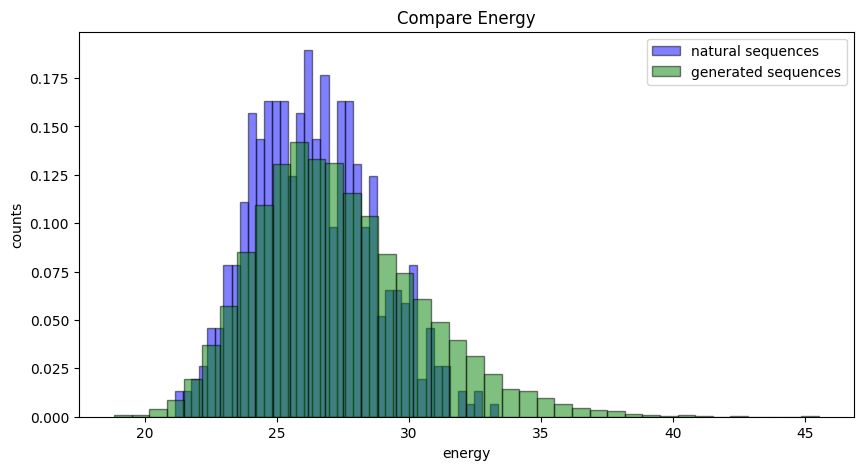

In [41]:
# histogram
num_bins = 40
plt.figure(figsize=(10, 5))
plt.hist(energy_nat_intloop, label="natural sequences", bins=num_bins, alpha=0.5, color="blue", edgecolor="black", density=true)
plt.hist(energy_gen_intloop, label="generated sequences", bins=num_bins, alpha=0.5, color="green", edgecolor="black", density=true)
plt.title("Compare Energy")
plt.xlabel("energy")
plt.ylabel("counts")
plt.legend()
plt.show()

# **Section 2:** Secondary Structure Prediction  
---  
## **Task 1:** Visualize the secondary structure of the Internal Loop RNA family  

The file "/content/data/structures_1.txt" contains the **TRUE secondary structure** of the Internal Loop RNA. Use the ```read_secondary_structure()``` function to load the file, then plot it using the code provided below.


```julia
contact_matrix = read_secondary_structure(file_path::String)
"""
Read the secondary structure information from a file.

Parameters:
- file_path: Path to the file containing the secondary structure information (use " ").

Output:
- contact_matrix: Matrix where each element (i, j) contains either 1 or 0, indicating whether residues i and j form a contact or not.
"""

```


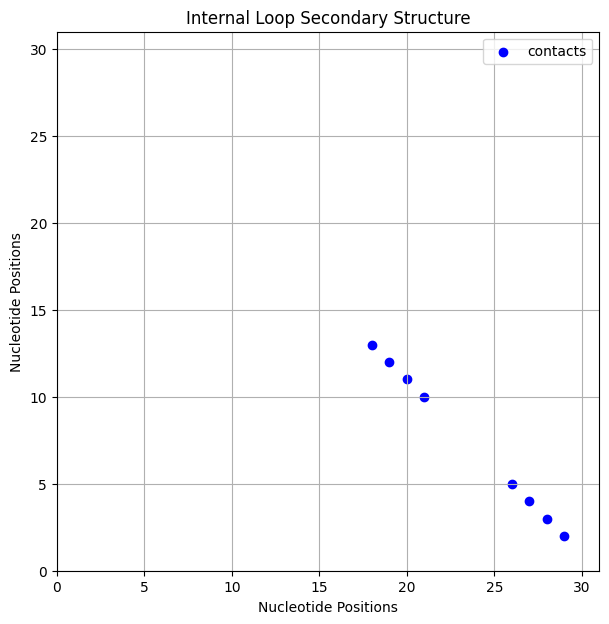

In [42]:
# read contact map from file
contact_matrix_intloop = read_secondary_strucuture("/content/data/structures_1.txt")

# plot contacts
contacts = findall(x -> x .> 0, contact_matrix_intloop)
x = getindex.(contacts, 1)
y = getindex.(contacts, 2)
plt.figure(figsize=(7, 7))
plt.scatter(y, x, label="contacts", color="blue")
plt.xlim(0, 31)
plt.ylim(0, 31)
plt.title("Internal Loop Secondary Structure")
plt.xlabel("Nucleotide Positions")
plt.ylabel("Nucleotide Positions")
plt.grid()
plt.legend()
plt.show()

---  
## **Task 2:** Predict the contacts of the Internal Loop RNA using the DCA model and compare them to the true contacts.  

Use the ```frobenius_norm()``` function to calculate the norm of the coupling matrix **J**. Then, use the ```plot_contact_map()``` function to visualize the predicted contact map and compare it to the true contact map.


```julia
J_normalized = frobenius_norm(J::Matrix{Float}, q::Int, L::Int)
"""
Calculate the Frobenius norm of the coupling matrix.

Parameters:
- J: Coupling matrix representing pairwise interactions.
- q: Number of nucleotides.
- L: Length of the sequence.

Output:
- J_normalized: LxL matrix containing the Frobenius norm of the coupling matrix.
"""
```

```julia
plot_contact_map(predicted_contact_matrix::Matrix{Float}, true_contact_matrix::Matrix{Int}, threshold::Float)
"""
Plot the contact map based on predicted and true contact matrices.

Parameters:
- predicted_contact_matrix: LxL matrix containing predicted contact values.
- true_contact_matrix: True contact matrix.
- threshold: Threshold value for cutting off the predicted contact matrix (try with 1).
"""
```

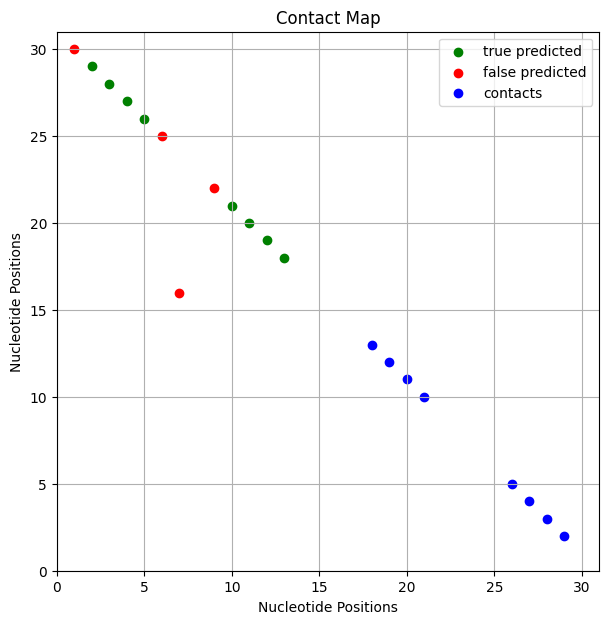

In [43]:
threshold = 3
J_intloop_normalized = frobenius_norm(J_intloop, q, L)
plot_contact_map(J_intloop_normalized, contact_matrix_intloop, threshold)

## - A link $(i, j)$ is considered a predicted contact only if $J_{ij}^{norm} \geq \text{threshold}$. Adjust the **threshold** to improve the clarity of the secondary structure signal.  
## - Why do you think the pairings **(6,25)** and **(9,22)** are so challenging to distinguish from the true contacts?

# **Section 3:** Predicting Fitness in a *Deep Mutational Scan* (DMS)  

## Exploring another RNA family: the **hairpin**  

> In the *data* folder, you’ll find several files:  
> - Training sequences: "/content/data/train_sequences_2.fasta" (natural hairpin sequences).  
> - DMS sequences: "/content/data/DMS_2.fasta" (mutated sequences for prediction).  
> - Experimental fitness: "/content/data/fitness_DMS_2.txt" (measured fitness values for the DMS sequences).  

---  
## **Task 1:** How can we predict fitness outcomes accurately in a DMS experiment?  

Use the ```read_fitness()``` function to load the fitness file and ```read_fasta()``` to load the DMS sequences. Train a model on the new hairpin dataset, then use **J** and **h** from the model to predict the fitness of the DMS sequences. (Hint: you can do this easily with one of the previously used functions!). Finally, plot the true fitness against your predictions using ```plot_DMS_prediction()```. Discuss the results.
```julia
fitness = read_fitness(file_path::String)
"""
Read fitness values from a .txt file.

Parameters:
- file_path: Path to the .txt file containing the fitness values.

Output:
- fitness: Vector containing the fitness values.
"""
```


```julia
plot_DMS_prediction(fitness, score_vector)
"""
Plot experimental fitness against prediction scores for each mutation.

Parameters:
- fitness: Vector containing the experimental fitness of each mutation.
- score_vector: Vector containing the prediction score for each mutation.
"""

```


In [44]:
data_hirpin = read_fasta("/content/data/train_sequences_2.fasta")
data_DMS = read_fasta("/content/data/DMS_2.fasta")
fitness_DMS = read_fitness( "/content/data/fitness_DMS_2.txt")

output_file_hirpin = "output_hirpin.txt"
results_hirpin = eaDCA(q, lambda, nchains, data_hirpin, output_file_hirpin);

Fully connected model has 435 edges and a score around ~ 0.95

L = 30               Profile Model :    Score = -0.003    <E> = 41.02    log(Z) = 0.0   S = 41.02   e_t  = 0.31

[1  30]  iter: 1   edges: 1   complex: 0.23%
[10  21]  iter: 2   edges: 2   complex: 0.46%
[8  23]  iter: 3   edges: 3   complex: 0.69%
[6  25]  iter: 4   edges: 4   complex: 0.92%
[5  26]  iter: 5   edges: 5   complex: 1.15%
[3  28]  iter: 6   edges: 6   complex: 1.38%
[7  24]  iter: 7   edges: 7   complex: 1.61%
[9  22]  iter: 8   edges: 8   complex: 1.84%
[4  27]  iter: 9   edges: 9   complex: 2.07%
[2  29]  iter: 10   edges: 10   complex: 2.3%
[11  20]  iter: 11   edges: 11   complex: 2.53%
[12  19]  iter: 12   edges: 12   complex: 2.76%
[29  30]  iter: 13   edges: 13   complex: 2.99%
[11  19]  iter: 14   edges: 14   complex: 3.22%
[13  18]  iter: 15   edges: 15   complex: 3.45%   Score = 0.828    <E> = 33.25    log(Z) = 0.25   S = 33.5   e_t  = 4.32
[12  17]  iter: 16   edges: 16   complex: 3.68%
[13  24]  i

In [45]:
gen_sequences_hirpin = results_hirpin[3]
J_hirpin = results_hirpin[4]
h_hirpin = results_hirpin[5]
energy_DMS_hirpin = sequences_energy(data_DMS, q, h_hirpin, J_hirpin);

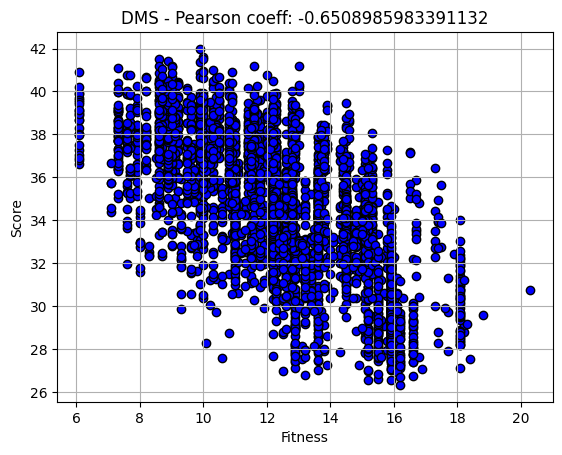

In [46]:
plot_DMS_prediction(fitness_DMS, energy_DMS_hirpin)

# **(BONUS) Section 4:** Family assignment

### Considering the two RNA families we've examined (*hairpin* and *interior loop*), we aim to classify a generic sequence into one of these two families. How can we tackle this challenge?

---
# **Task 1:** perform a logistic regression and compute the accuracy.


> - File with sequences to assign and true label: "/content/data/sequences_to_assign.fasta"




```julia
sequences, labels = read_sequences_and_labels(file_path::String)
"""
Read sequences and their corresponding labels from a file.

Parameters:
- file_path: Path to the file containing sequences and labels.

Returns:
- sequences: Vector of sequences read from the file.
- labels: Vector of labels corresponding to each sequence.
"""
```



In [47]:
# assign the corresponding variable
data_hirpin = data_hirpin
data_intloop = data_intloop
sequences_to_assign, labels = read_sequences_and_labels("/content/data/sequences_to_assign.fasta");

In [48]:
@pyimport sklearn.linear_model as lm
@pyimport sklearn.metrics as metrics


LR = lm.LogisticRegression()

# create dataset containing sequences of family 1 and 2
data_train = vcat(data_intloop, data_hirpin)
# define the labels
labels_tot = ones(size(data_train, 1))
labels_tot[size(data_hirpin, 1) + 1 : end] .+= 1;

# fit logistic regression
LR.fit(one_hot_encoding(data_train, q), labels_tot)
LR_prediction = LR.predict(one_hot_encoding(sequences_to_assign, q))

# compute the score of the logistic regression
metrics.accuracy_score(LR_prediction, labels)

0.54

---
## **Task 2:** Determine a method to assign labels to the sequences utilizing the trained models and compute its accuracy.
Hint: Plot the histogram of the energies for the sequences to assign, computed with one of the two models. What do you observe? How can you differentiate between hairpin and internal loop RNA?

In [49]:
energy_seqtossign = sequences_energy(sequences_to_assign, q, h_hirpin, J_hirpin);

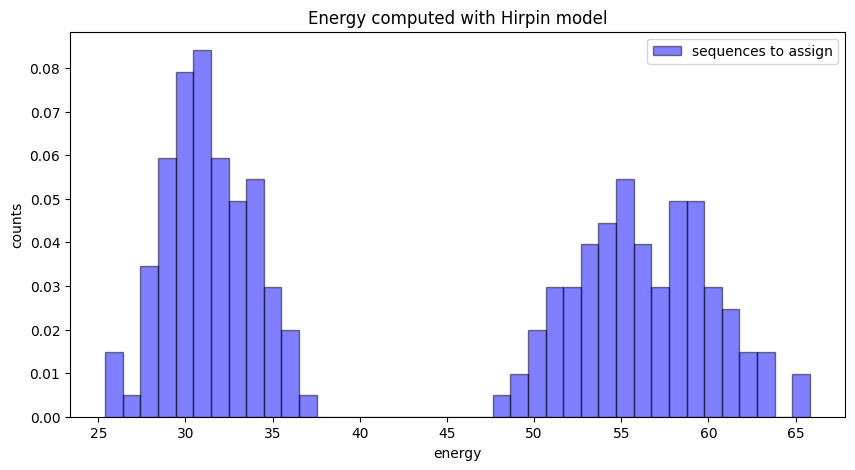

In [50]:
# histogram
num_bins = 40
plt.figure(figsize=(10, 5))
plt.hist(energy_seqtossign, label="sequences to assign", bins=num_bins, alpha=0.5, color="blue", edgecolor="black", density=true)
plt.title("Energy computed with Hirpin model")
plt.xlabel("energy")
plt.ylabel("counts")
plt.legend()
plt.show()

In [51]:
N = size(sequences_to_assign, 1) # number of sequences to assign
DCA_prediction = zeros(N)

for i in 1:N
  if energy_seqtossign[i] <= 45
    DCA_prediction[i] = 2
  else
    DCA_prediction[i] = 1
  end
end

metrics.accuracy_score(DCA_prediction, labels)

1.0

---
# **Mutable sites:** Mutations tend to be more harmful in areas with exceptionally low mutability. A proxy for the mutability of a sequence is represented by the model entropy.


```julia
ci_entropy = context_independent_entropy(data, q)

"""
Compute context-independent entropy for given dataset.

Parameters:
- data: Input data for entropy calculation.
- q: Number of nucleotides.

Returns:
- ci_entropy: Context-independent entropy.
"""

```

```julia
cd_entropy = context_dependent_entropy(sequence::Vector, L::Int, q::Int, J::Matrix{Float}, h::Vector{Float})
"""
Compute context-dependent entropy for a given sequence.

Parameters:
- sequence: Vector representing the sequence.
- L: Length of the sequence.
- q: Number of nucleotides.
- J: Coupling matrix representing pairwise interactions.
- h: Vector of local fields.

Returns:
- cd_entropy: Vector containing context-dependent entropy for each position in the sequence.
"""
```

In [52]:
# set J_2 and h_2 as the parameters of the Internal Loop RNA model
J_hirpin = J_hirpin
h_hirpin = h_hirpin;

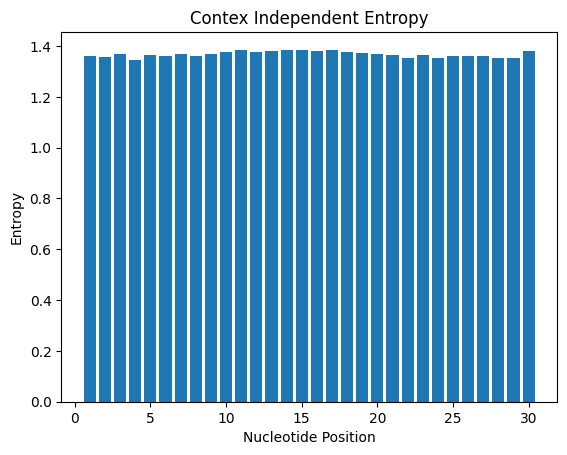

In [53]:
# compute context INDEPENDENT entropy from the data
CIE = context_independent_entropy(data_hirpin, q)

plt.bar(1:L, CIE)
plt.title("Contex Independent Entropy")
plt.xlabel("Nucleotide Position")
plt.ylabel("Entropy");

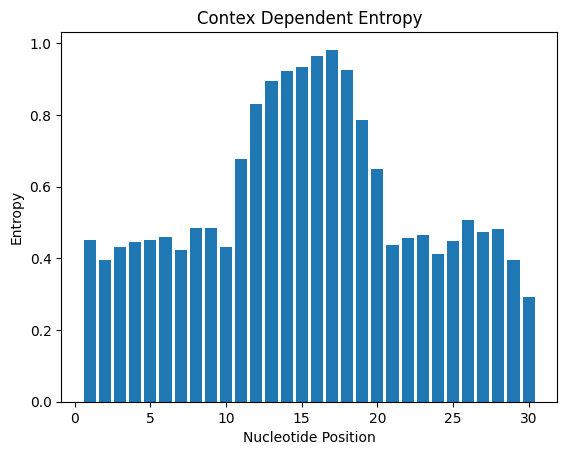

In [54]:
# compute context DEPENDENT entropy from the model
average_CDE = zeros(Float64, L)
for i in 1:size(data_intloop, 1)
  average_CDE  .+= context_dependent_entropy(data_hirpin[i, :], L, q, J_hirpin, h_hirpin)
end

average_CDE = average_CDE ./ size(data_intloop, 1)
plt.bar(1:L, average_CDE)
plt.title("Contex Dependent Entropy")
plt.xlabel("Nucleotide Position")
plt.ylabel("Entropy");

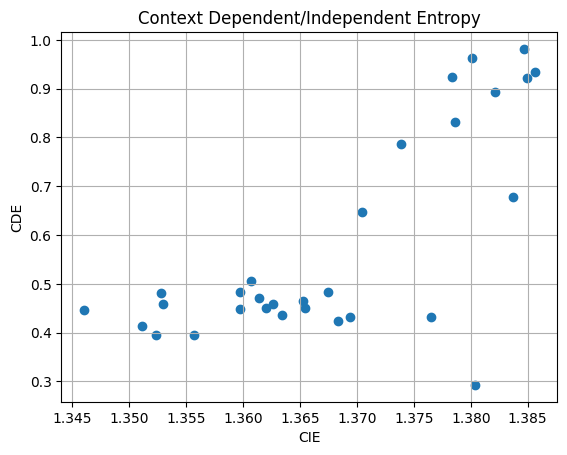

In [55]:
plt.scatter(CIE, average_CDE);
plt.title("Context Dependent/Independent Entropy")
plt.xlabel("CIE");
plt.ylabel("CDE");
plt.grid();

# Need Help?

* Learning: https://julialang.org/learning/
* Documentation: https://docs.julialang.org/
* Questions & Discussions:
  * https://discourse.julialang.org/
  * http://julialang.slack.com/
  * https://stackoverflow.com/questions/tagged/julia

If you ever ask for help or file an issue about Julia, you should generally provide the output of `versioninfo()`.

Add new code cells by clicking the `+ Code` button (or _Insert_ > _Code cell_).

Have fun!

<img src="https://raw.githubusercontent.com/JuliaLang/julia-logo-graphics/master/images/julia-logo-mask.png" height="100" />